In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
!pip install us
import us

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving insurance_claims.csv to insurance_claims.csv


# Q1: Can we predict the total claim amount using policyholder tenure, deductible amount, age, and incident hour of the day'?

## Part I: Preprocessing

In [ ]:
# Import insurance claims and motor vehicle registration data

insurance_claims_df = pd.read_csv("insurance_claims.csv")

url = "https://www.fhwa.dot.gov/policyinformation/statistics/2015/mv1.cfm"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')
all_motor_vehicles_df = pd.read_html(StringIO(str(table)))[0]

In [ ]:
# Categorize time of day into groups
def time_of_day(hour):
    if hour >= 5 and hour < 12:
        return 'Morning 5AM-12PM'
    elif hour >= 12 and hour < 17:
        return 'Afternoon 12PM-5PM'
    elif hour >= 17 and hour < 21:
        return 'Evening 5PM-9PM'
    else:
        return 'Night 9PM-5AM'

# Create new column for time of day
insurance_claims_df['time_of_day'] = insurance_claims_df['incident_hour_of_the_day'].apply(time_of_day)

**NOTE:** I encoded incident hours of the day into time of day as we did in our EDA. I used time_of_day (encoded variable) instead of incident_hour_of_the_day in all of the models. The encoded variable actually produced lower r-squared and accuracy scores and higher RSME.

Also I took witnesses as a feature out of all models because it actually dropped the accuracy and r-squared values and raised the RSME.

## Part II: Fit Machine Learning Models

# **BASELINE MODEL**

In [ ]:
# Create a target y variable
y = insurance_claims_df['total_claim_amount']

# Train/test split
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)
y_baseline = np.full(len(y_test), y_train.mean())

r2 = r2_score(y_test, y_baseline)
rmse = np.sqrt(mean_squared_error(y_test, y_baseline))

print("Baseline R^2 score:", round(r2, 4))
print("Baseline RMSE:", round(rmse, 2))

Baseline R^2 score: -0.0102
Baseline RMSE: 25928.38


### Model 1: Linear regression (bad results)

In [ ]:
# Define features and target
features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age']

# Split data into X and y
X = insurance_claims_df[features]
y = insurance_claims_df['total_claim_amount']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression R^2 score:", round(r2, 4))
print("Linear Regression RMSE:", round(rmse, 2))

Linear Regression R^2 score: 0.0512
Linear Regression RMSE: 25128.6


### Model 2: Random Forest - Regressor (worst results)

In [ ]:
# Fit Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict and evaluate
rf_pred = rf_model.predict(X_test_scaled)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest R^2 score:", round(rf_r2, 4))
print("Random Forest RMSE:", round(rf_rmse, 2))

Random Forest R^2 score: 0.0106
Random Forest RMSE: 25660.54


### Model 3: Random Forest Classifier (Total Claims split into 3 categories)
Then decided to make total claim amount categorical by spliting into lower, middle and upper 33% and used random forest classifier

In [ ]:
# Create categorical target of lower 33%, middle 33%, upper 33%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=3, labels=[0, 1, 2])
y_class.value_counts()

,count
total_claim_amount,
1,334
0,333
2,333


Random Forest Classifier Accuracy: 0.435
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.44      0.45        73
           1       0.47      0.46      0.46        68
           2       0.37      0.41      0.39        59

    accuracy                           0.43       200
   macro avg       0.43      0.43      0.43       200
weighted avg       0.44      0.43      0.44       200



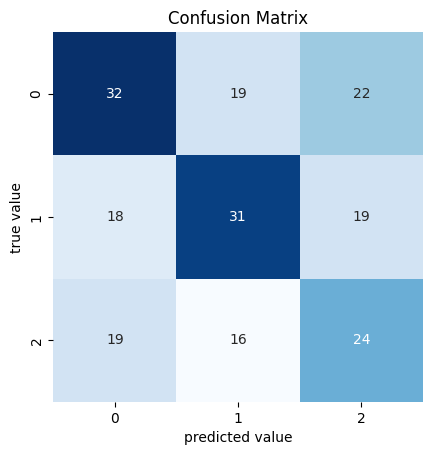

In [ ]:
# Create categorical target of lower 33%, middle 33%, upper 33%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=3, labels=[0, 1, 2])

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit a Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict
y_pred = clf.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

### Random Forest Classifier (Total Claims split into 2 categories)

Results were not great: so then decided to make total claim amount categorical by spliting into lower and upper 33% and used random forest classifier


In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])
y_class.value_counts()

,count
total_claim_amount,
0,500
1,500


# **BASELINE MODEL**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
y_baseline = np.ones(len(y_test))
baseline_accuracy = accuracy_score(y_test, y_baseline)
baseline_accuracy

0.475

Random Forest Classifier Accuracy: 0.545
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.52      0.55       105
           1       0.52      0.57      0.54        95

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.55      0.55      0.55       200

Linear Regression R^2 score: -0.8246
Linear Regression RMSE: 0.67


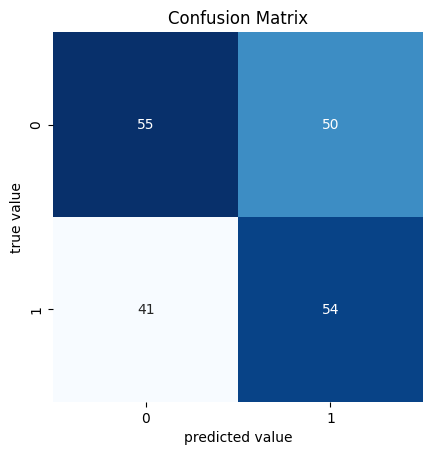

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict
y_pred = clf.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

# R^2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression R^2 score:", round(r2, 4))
print("Linear Regression RMSE:", round(rmse, 2))

# Confusion Matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

### Model 4: Support Vector Machine (Total Claims split into 3 categories)

Then decided to make total claim amount categorical by spliting into lower, middle and upper 33% and used SVC

#### SVM using Linear Kernel (3 categories)

SVC (Linear) Accuracy: 0.425
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.59      0.53        73
           1       0.37      0.21      0.26        68
           2       0.38      0.47      0.42        59

    accuracy                           0.42       200
   macro avg       0.41      0.42      0.41       200
weighted avg       0.42      0.42      0.41       200

Linear Regression R^2 score: -0.7249
Linear Regression RMSE: 1.06


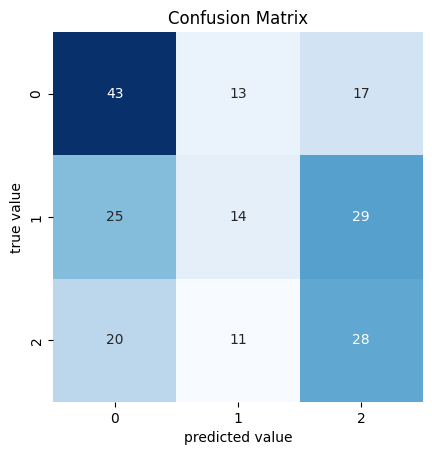

In [ ]:
# Create categorical target of lower 33%, middle 33%, upper 33%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=3, labels=[0, 1, 2])

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with classification target
svc_model = SVC(kernel='linear', C=1.0, random_state=42)
svc_model.fit(X_train_scaled, y_train)

# Predict
svc_pred = svc_model.predict(X_test_scaled)

# Evaluate
svm_acc = accuracy_score(y_test, svc_pred)
print("SVC (Linear) Accuracy:", round(svm_acc, 4))
print("Classification Report:\n", classification_report(y_test, svc_pred))

# R^2 and RMSE
r2 = r2_score(y_test, svc_pred)
rmse = np.sqrt(mean_squared_error(y_test, svc_pred))

print("Linear Regression R^2 score:", round(r2, 4))
print("Linear Regression RMSE:", round(rmse, 2))

# Confusion Matrix
mat = confusion_matrix(y_test, svc_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

#### SVM using RBF Kernel (3 categories)

SVC Accuracy: 0.385
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.53      0.48        73
           1       0.38      0.29      0.33        68
           2       0.31      0.31      0.31        59

    accuracy                           0.39       200
   macro avg       0.38      0.38      0.37       200
weighted avg       0.38      0.39      0.38       200



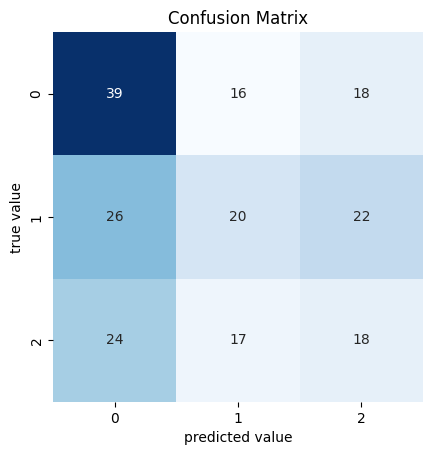

In [ ]:
# Create categorical target of lower 33%, middle 33%, upper
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=3, labels=[0, 1, 2])

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with classification target
svc_model = SVC(kernel='rbf', C=1.0, random_state=42)
svc_model.fit(X_train_scaled, y_train)

# Predict
svc_pred = svc_model.predict(X_test_scaled)

# Evaluate
svm_acc = accuracy_score(y_test, svc_pred)
print("SVC Accuracy:", round(svm_acc, 4))
print("Classification Report:\n", classification_report(y_test, svc_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, svc_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

results were not great: so then decided to make total claim amount categorical by spliting into lower and upper 50% and used SVC

### Support Vector Machine (Total Claims split into 2 categories)

#### SVM using Linear Kernel (2 categories) **BEST MODEL FOR Q1**

SVC (Linear) Accuracy: 0.57
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.55      0.57       105
           1       0.54      0.59      0.57        95

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57       200



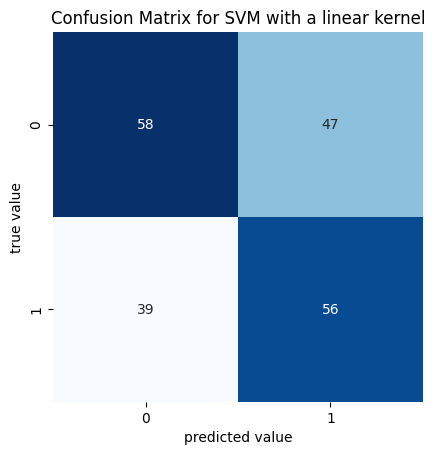

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age']

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with classification target
svc_model = SVC(kernel='linear', C=1000.0, random_state=42)
svc_model.fit(X_train_scaled, y_train)

# Predict
svc_pred = svc_model.predict(X_test_scaled)

# Evaluate
svm_acc = accuracy_score(y_test, svc_pred)
print("SVC (Linear) Accuracy:", round(svm_acc, 4))
print("Classification Report:\n", classification_report(y_test, svc_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, svc_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix for SVM with a linear kernel')
plt.xlabel('predicted value')
plt.ylabel('true value');

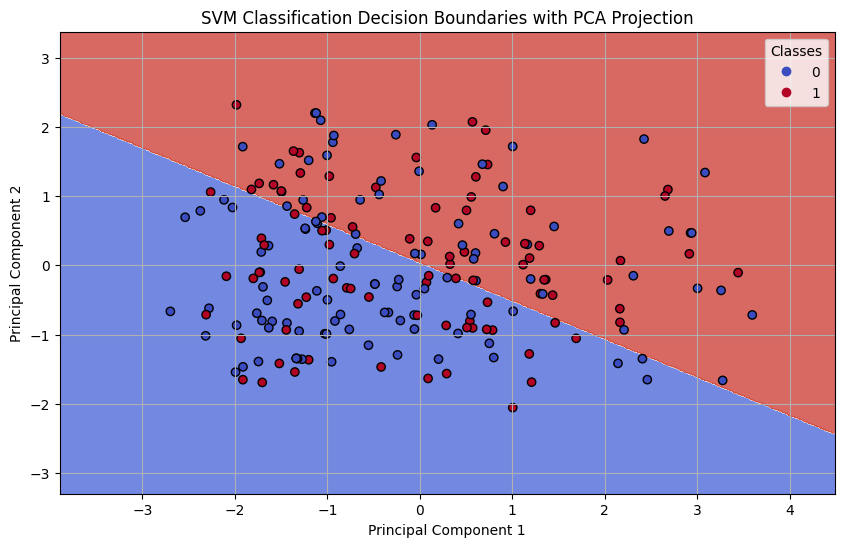

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fit SVM on PCA-transformed data
svc_pca_model = SVC(kernel='linear', C=1000.0, random_state=42)
svc_pca_model.fit(X_train_pca, y_train)

# Create a mesh to plot decision boundaries
h = .02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict over mesh
Z = svc_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Classification Decision Boundaries with PCA Projection')
plt.grid(True)
plt.show()


<ipython-input-18-49e658ea5bcb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients, y=feature_names, palette='coolwarm')


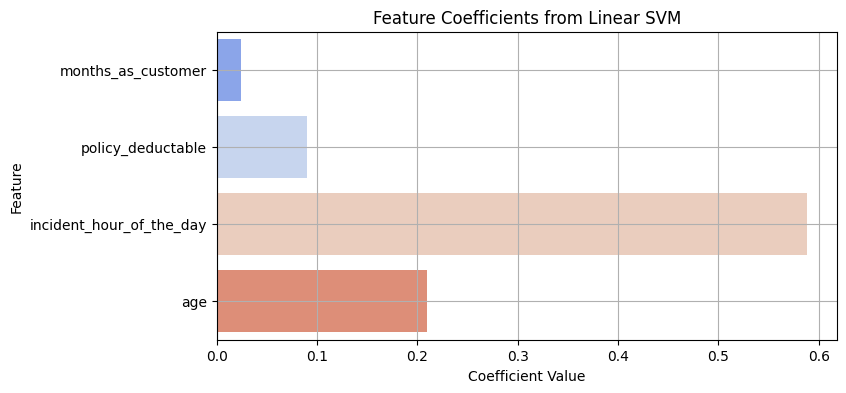

In [ ]:
# Only works with linear kernel
feature_names = X.columns.tolist()
coefficients = svc_model.coef_[0]

plt.figure(figsize=(8, 4))
sns.barplot(x=coefficients, y=feature_names, palette='coolwarm')
plt.title("Feature Coefficients from Linear SVM")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

#### Use GridSearch to Tune Hyperparameter for SVM
Find the best 'C' parameter for data in SVM using Linear Kernel model (2 categories)

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age']

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_scaled, y_train)

# Best parameter after tuning
print(grid.best_params_)
print(grid.best_estimator_)

# Make prediction
grid_predictions = grid.predict(X_test_scaled)

# Accuracy score
svm_acc = accuracy_score(y_test, grid_predictions)
print("SVC (Linear) Accuracy:", round(svm_acc, 4))

# Classification report
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.581 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.525 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.556 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.588 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.525 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.581 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.525 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.556 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.588 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.525 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.581 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

#### SVM using RBF Kernel (2 categories)

SVC Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.51      0.55       105
           1       0.52      0.59      0.55        95

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.55      0.55      0.55       200



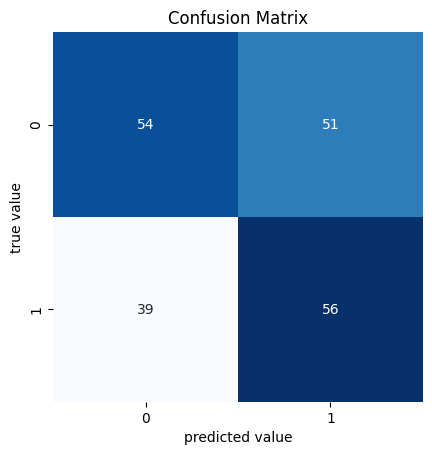

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with classification target
svc_model = SVC(kernel='rbf', C=1.0, random_state=42)
svc_model.fit(X_train_scaled, y_train)

# Predict
svc_pred = svc_model.predict(X_test_scaled)

# Evaluate
svm_acc = accuracy_score(y_test, svc_pred)
print("SVC Accuracy:", round(svm_acc, 4))
print("Classification Report:\n", classification_report(y_test, svc_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, svc_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

### Model 5: Logistic Regression (Total Claims split into 2 categories)

Based on the above models, we see that total claims split into 2 categories yields a higher accuracy score. So our 5th model only use the two categories in our total_claim_amount target label.

Logistic Regression Accuracy: 0.545
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.51      0.54       105
           1       0.52      0.58      0.55        95

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.55      0.55      0.54       200



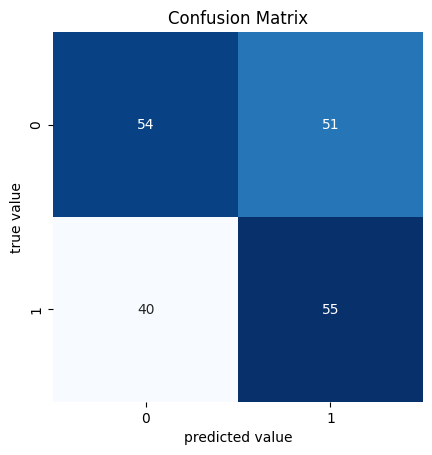

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with classification target
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", round(lr_acc, 4))
print("Classification Report:\n", classification_report(y_test, lr_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, lr_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');


### Model 6: Naive Bayes (Total Claims split into 2 categories)

Gaussian Naive Bayes Accuracy: 0.565
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.64      0.61       105
           1       0.55      0.48      0.51        95

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



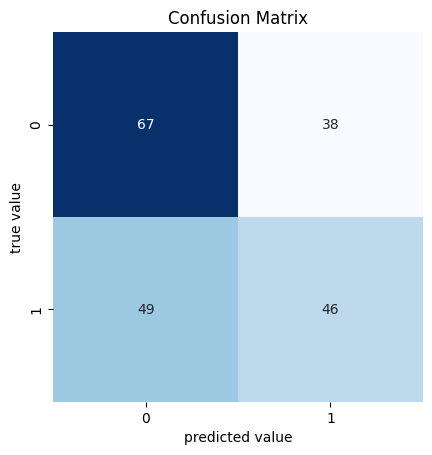

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Gausian Naive Bayes with classification target
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Predict
nb_pred = nb_model.predict(X_test_scaled)

# Evaluate
nb_acc = accuracy_score(y_test, nb_pred)
print("Gaussian Naive Bayes Accuracy:", round(nb_acc, 4))
print("Classification Report:\n", classification_report(y_test, nb_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, nb_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');


### KNN (Total Claims split into 2 categories)

KNN Accuracy: 0.525
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.73      0.62       105
           1       0.50      0.29      0.37        95

    accuracy                           0.53       200
   macro avg       0.52      0.51      0.49       200
weighted avg       0.52      0.53      0.50       200



Text(0.5, 1.0, 'Confusion Matrix')

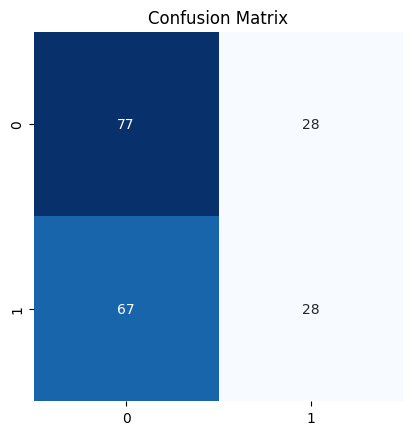

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

X = insurance_claims_df[features]
X = X.loc[y_class.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit KNN model
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_scaled, y_train)

# Predict
knn_pred = knn_model.predict(X_test_scaled)

# Evaluate
knn_acc = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", round(knn_acc, 4))
print("Classification Report:\n", classification_report(y_test, knn_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, knn_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')

## Part III: Add Vechicle Registration dataset as predictor to refit ML Models

Still not the best results so decided to add vechicle registration to see if this could help the model.

Based on Part II, we see that classifier does a better job than regressor. In this part, we fit our data to Random Forest Classifier, SVM, and Logistic Regression. These three models are the ones performs best based on part II.

In [ ]:
# Select and rename the relevant columns
vehicle_reg_df = all_motor_vehicles_df[[('STATE', 'STATE'), ('ALL MOTOR VEHICLES', 'TOTAL'), ('ALL MOTOR VEHICLES', 'PUBLICLY OWNED')]].copy()
vehicle_reg_df.columns = ['state', 'total_vehicles','public_vehicles']

# Create a mapping from full state names to abbreviations using the us.states package
state_abbrev_map = {state.name: state.abbr for state in us.states.STATES}

# Add a new column with state abbreviations to match with the insurance claims data
vehicle_reg_df['state_abbr'] = vehicle_reg_df['state'].map(state_abbrev_map)

# Merge insurance claims with vehicle registration data using the state abbreviation
merged_df = insurance_claims_df.merge(vehicle_reg_df, left_on='incident_state', right_on='state_abbr', how='inner')

In [ ]:
# Calculate the 75th percentile
threshold = merged_df['total_vehicles'].quantile(0.75)

# Create a new column categorizing states as 'Low'
merged_df['registration_category'] = 'Low'
# Reassign to 'High' where the total number of vehicles is greater than or equal to the threshold
merged_df.loc[merged_df['total_vehicles'] >= threshold, 'registration_category'] = 'High'

In [ ]:
merged_df[['months_as_customer', 'age', 'policy_deductable', 'registration_category', 'total_claim_amount', 'incident_hour_of_the_day', 'incident_severity']]
merged_df['incident_hour_of_the_day'].max()

23

Note that "registration_category" is categorical feature.

In [ ]:
features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age', 'registration_category']
X = merged_df[features]
print(X)

     months_as_customer  policy_deductable  incident_hour_of_the_day  age  \
0                   328               1000                         5   48   
1                   228               2000                         8   42   
2                   134               2000                         7   29   
3                   256               2000                         5   41   
4                   228               1000                        20   44   
..                  ...                ...                       ...  ...   
995                   3               1000                        20   38   
996                 285               1000                        23   41   
997                 130                500                         4   34   
998                 458               2000                         2   62   
999                 456               1000                         6   60   

    registration_category  
0                     Low  
1                  

### Random Forest Classifier Model

Random Forest Classifier Accuracy: 0.505
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.52      0.53       105
           1       0.48      0.48      0.48        95

    accuracy                           0.51       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.51      0.51      0.51       200



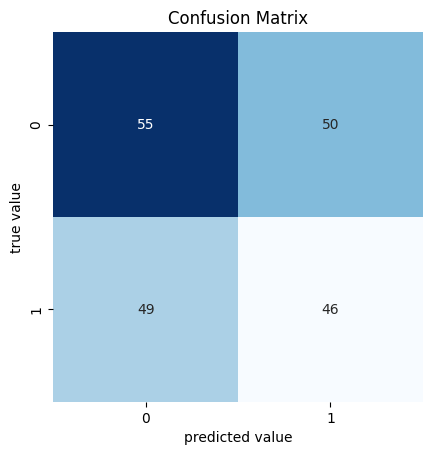

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

# Define features and target
features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age', 'registration_category']
numerical_features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age']

y = y_class
X = merged_df[features]
X = pd.get_dummies(X, drop_first=True,columns=['registration_category'])


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Fit Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

### Support Vector Machine Model (with Linear Kernal)

SVC Accuracy: 0.57
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.55      0.57       105
           1       0.54      0.59      0.57        95

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57       200

RMSE: 0.6557
R^2 Score: -0.7243


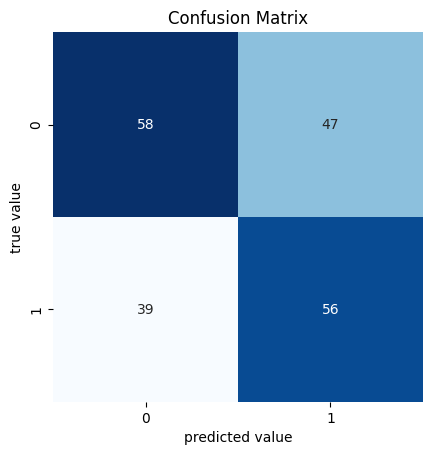

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

# Define features and target
features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age', 'registration_category']
numerical_features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age']

y = y_class
X = merged_df[features]
X = pd.get_dummies(X, drop_first=True,columns=['registration_category'])


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Train SVM with classification target
svc_model = SVC(kernel='linear', C=1.0, random_state=42)
svc_model.fit(X_train_scaled, y_train)

# Predict
svc_pred = svc_model.predict(X_test_scaled)

# Evaluate
svm_acc = accuracy_score(y_test, svc_pred)
print("SVC Accuracy:", round(svm_acc, 4))
print("Classification Report:\n", classification_report(y_test, svc_pred))

# R^2 and RMSE
rmse = np.sqrt(mean_squared_error(y_test, svc_pred))
r2 = r2_score(y_test, svc_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Confusion Matrix
mat = confusion_matrix(y_test, svc_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

### Logistic Regression Model

Logistic Regression Accuracy: 0.545
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.51      0.54       105
           1       0.52      0.58      0.55        95

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.55      0.55      0.54       200

RMSE: 0.6745
R^2 Score: -0.8246


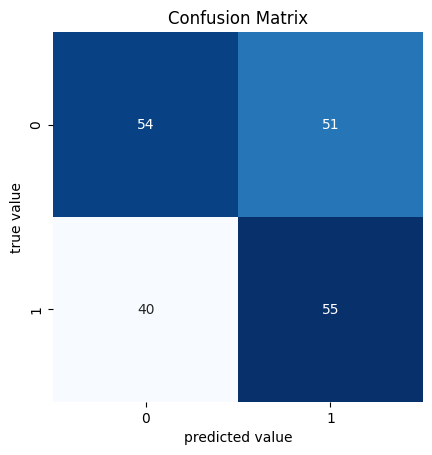

In [ ]:
# Create categorical target of lower 50% and upper 50%
y_class = pd.qcut(insurance_claims_df['total_claim_amount'], q=2, labels=[0, 1])

# Define features and target
features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age', 'registration_category']
numerical_features = ['months_as_customer', 'policy_deductable', 'incident_hour_of_the_day', 'age']

y = y_class
X = merged_df[features]
X = pd.get_dummies(X, drop_first=True,columns=['registration_category'])


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Train Logistic Regression with classification target
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", round(lr_acc, 4))
print("Classification Report:\n", classification_report(y_test, lr_pred))

# R^2 and RMSE
rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
r2 = r2_score(y_test, lr_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Confusion Matrix
mat = confusion_matrix(y_test, lr_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

# Q4: Can we predict whether an incident results in a total loss using time of day, number of witnesses, deductible amount, and age of customer? **NOTE** feature selection is still in progress so likely question slightly changes

In [ ]:
print(merged_df.columns)

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', '_c39', 'time_of_day',
       'state', 'total_vehicles', 'public_vehicles', 'state_abbr',
       'registration_category'],
      dtype='object')


In [ ]:
merged_df['is_total_loss'] = insurance_claims_df['incident_severity'] == 'Total Loss'
merged_df['is_total_loss'].value_counts()

,count
is_total_loss,
False,720
True,280


# **BASELINE MODEL**

In [ ]:
y = merged_df['is_total_loss'].astype(int)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)
y_baseline = np.ones(len(y_test))
baseline_accuracy = accuracy_score(y_test, y_baseline)
baseline_accuracy

0.22

### Random Forest Classifier

Random Forest Classifier Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       156
           1       0.38      0.23      0.29        44

    accuracy                           0.75       200
   macro avg       0.59      0.56      0.57       200
weighted avg       0.71      0.75      0.72       200



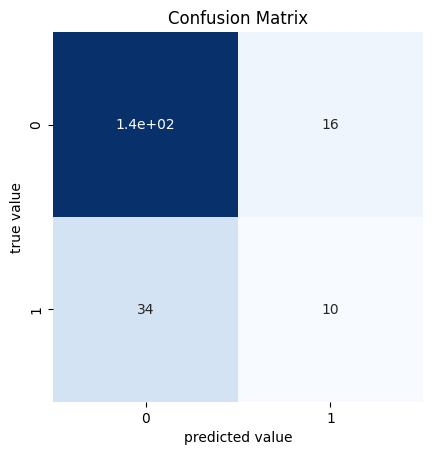

In [ ]:
# Convert boolean
merged_df['is_total_loss'] = (merged_df['incident_severity'] == 'Total Loss').astype(int)
y = merged_df['is_total_loss']
X = merged_df[['incident_hour_of_the_day','age', 'months_as_customer','policy_deductable']]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

# Predict
y_pred = clf.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

### Add 'registration_category' to fit Random Forest Classifier Model

Random Forest Classifier Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       156
           1       0.35      0.20      0.26        44

    accuracy                           0.74       200
   macro avg       0.57      0.55      0.55       200
weighted avg       0.70      0.74      0.71       200



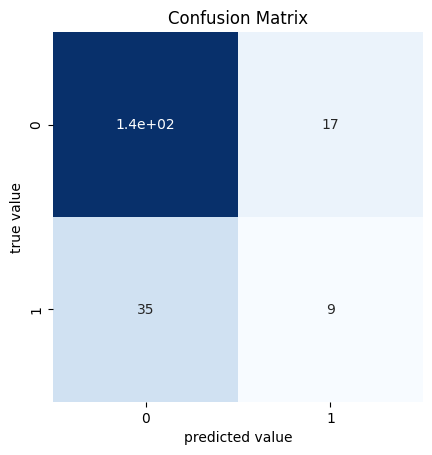

In [ ]:
# Convert boolean to string labels
insurance_claims_df['is_total_loss'] = insurance_claims_df['incident_severity'] == 'Total Loss'
merged_df['is_total_loss'] = insurance_claims_df['incident_severity'] == 'Total Loss'
merged_df['is_total_loss'] = insurance_claims_df['is_total_loss'].astype(int)
y = merged_df['is_total_loss']
X = merged_df[['incident_hour_of_the_day','age', 'months_as_customer','policy_deductable', 'registration_category']]
X = pd.get_dummies(X, drop_first=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

# Predict
y_pred = clf.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

### SVM Model **currently BEST MODEL even tho low accuracy because recall is high for class 1**

SVC Accuracy: 0.565
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.54      0.66       156
           1       0.29      0.66      0.40        44

    accuracy                           0.56       200
   macro avg       0.57      0.60      0.53       200
weighted avg       0.72      0.56      0.60       200



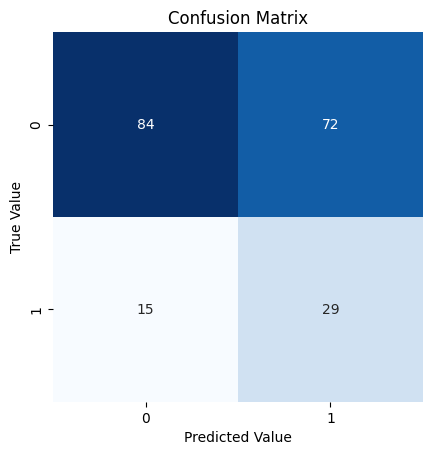

In [ ]:
# Convert boolean to integer labels (0 = Not Total Loss, 1 = Total Loss)
insurance_claims_df['is_total_loss'] = insurance_claims_df['incident_severity'] == 'Total Loss'
merged_df['is_total_loss'] = insurance_claims_df['is_total_loss'].astype(int)

# Define target and features
y = merged_df['is_total_loss']
X = merged_df[['incident_hour_of_the_day', 'age', 'months_as_customer', 'policy_deductable']]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with classification target
svc_model = SVC(kernel='rbf', C=5.0, random_state=42, class_weight='balanced')
svc_model.fit(X_train_scaled, y_train)

# Predict
svc_pred = svc_model.predict(X_test_scaled)

# Evaluate
svm_acc = accuracy_score(y_test, svc_pred)
print("SVC Accuracy:", round(svm_acc, 4))
print("Classification Report:\n", classification_report(y_test, svc_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, svc_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

### Logistic Regression

Logistic Regression Accuracy: 0.505
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.51      0.62       156
           1       0.22      0.48      0.30        44

    accuracy                           0.51       200
   macro avg       0.50      0.50      0.46       200
weighted avg       0.65      0.51      0.55       200



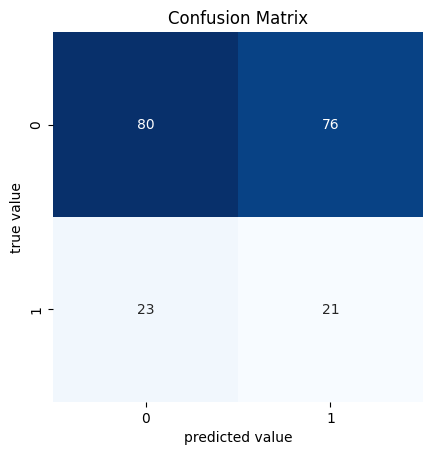

In [ ]:
insurance_claims_df['is_total_loss'] = insurance_claims_df['incident_severity'] == 'Total Loss'
merged_df['is_total_loss'] = insurance_claims_df['is_total_loss'].astype(int)

# Define target and features
y = merged_df['is_total_loss']
X = merged_df[['incident_hour_of_the_day','age', 'months_as_customer','policy_deductable', 'registration_category']]
X = pd.get_dummies(X, drop_first=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with classification target
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predict
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", round(lr_acc, 4))
print("Classification Report:\n", classification_report(y_test, lr_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, lr_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');

Decision Tree Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.55      0.66       156
           1       0.26      0.55      0.35        44

    accuracy                           0.55       200
   macro avg       0.53      0.55      0.50       200
weighted avg       0.69      0.55      0.59       200



<Figure size 1500x800 with 0 Axes>

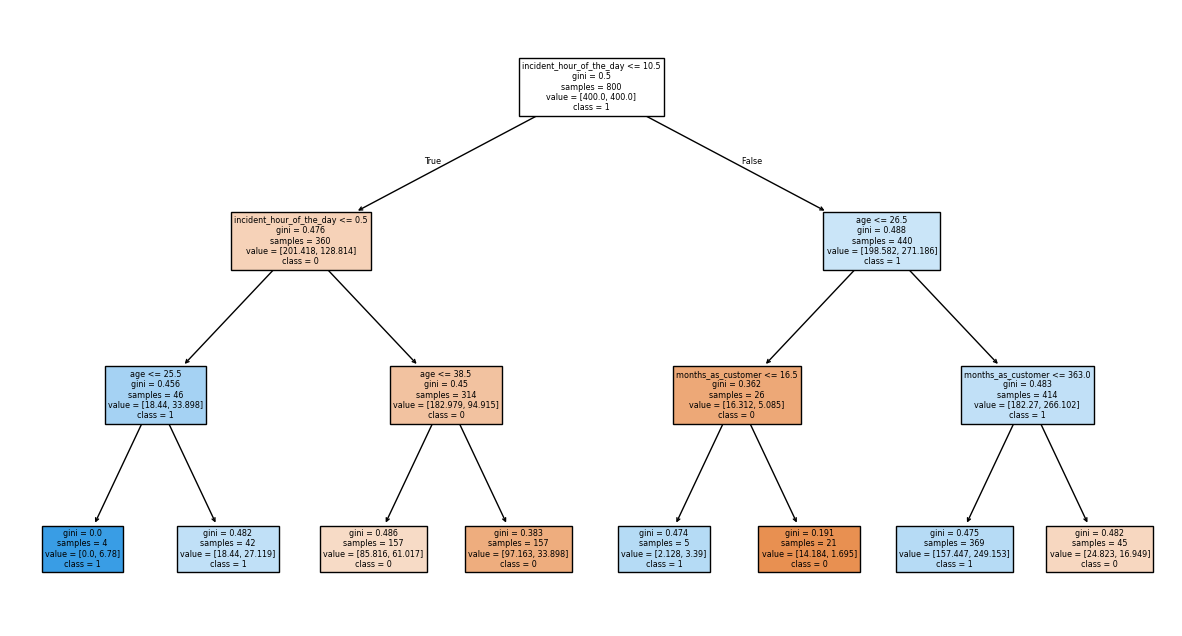

In [ ]:
# Target and features
insurance_claims_df['is_total_loss'] = insurance_claims_df['incident_severity'] == 'Total Loss'
merged_df['is_total_loss'] = insurance_claims_df['is_total_loss'].astype(int)

y = merged_df['is_total_loss']
X = merged_df[['incident_hour_of_the_day', 'age', 'months_as_customer','policy_deductable']]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3, criterion='gini', class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print("Decision Tree Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Classification Report:\n", classification_report(y_test, y_pred))


# Visualize the Tree
plt.figure(figsize=(15,8))
plt.figure(figsize=(15, 8))
plot_tree(clf,
          feature_names=X_train.columns,
          class_names=["0", "1"],
          filled=True)
plt.show()